# Project 6 Notebook - Neural Radiance Fields (NeRF)

Welcome to the Project 6 Notebook! In this project, you will learn:

1. Encoding scene information in a neural network and the value of positional encoding
2. How to build a Neural Radiance Field [NeRF](https://arxiv.org/abs/2003.08934) from a set of images
3. How to synthesize novel views from a NeRF

# Initialization
Run the cell below to import the necessary libaries and print the device that the code will be run on (GPU vs.CPU).
By default, you should get a GPU (i.e., the output is `cuda`).

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time
import torchvision
import src.vision as vision
from src.vision.utils import verify

device_type = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
device = torch.device(device_type)
print(device)

%load_ext autoreload
%autoreload 2

cuda


## Part 1: 2D Image Representation
We aim to explore the task of representing a 2D image using a neural network. Specifically, we encode 2D coordinates using positional encoding and fit the image using a multi-layer perceptron (MLP).

## Part 1(a): Implement a simple feedforward neural network model for 2D input.
Now, let's try to fit a 2D image with a multilayer perceptron (MLP)!
In class we learn that we can store an 2D image with a coordinate-based MLP (as shown in the figure below). The input to this MLP is 2D pixel coordinate (x, y) as a pair of floating point numbers, and the output is RGB color of the corresponding pixel. This is a simple supervised learning problem, and we can just use simple gradient descent to train the network weights and see what happens.  

We provde a base implementation with 3 linear layers. Complete the codes of `Model2d` in src/part1.py, and run the tests in the next cell.

<!-- ![1650569617136.jpg]() -->
<div>
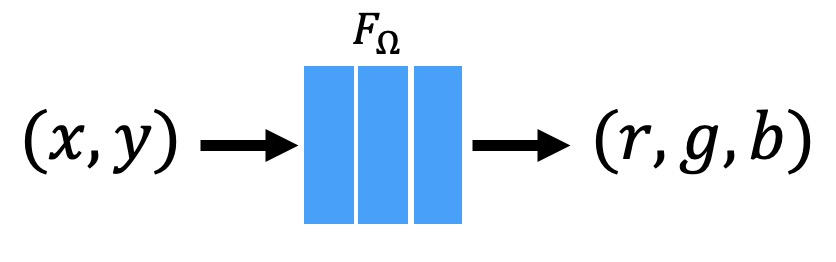
</div>

In [59]:

from tests.test_part1 import test_model_2d_shape

print("Testing your Model2d:", verify(test_model_2d_shape))

Testing your Model2d: "Correct"


## Part 1(b): 2D Image Fitting

We first load and visualize our training data, a famous artwork "Starry Night" from Vincent Van Gogh.

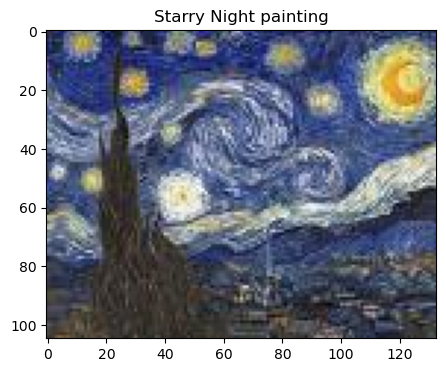

In [60]:
# Load painting image
painting = imageio.imread("Starry-Night-canvas-Vincent-van-Gogh-New-1889_12.jpg")
painting = torch.from_numpy(np.array(painting, dtype=np.float32)/255.).to(device)
height_painting, width_painting = painting.shape[:2] 

plt.figure(figsize=(13, 4))
plt.title("Starry Night painting")
plt.imshow(painting.detach().cpu().numpy())
plt.show()

You can run the next cell to begin the training process. Let's assess the performance of this basic implementation. If it doesn't accurately learn the target "Starry Night" painting, don't worry—this is expected. The output image is intended to reconstruct only the horizontal textures and color patterns, without capturing fine details. The PSNR is expected to be just above 15.

Iteration 0  Loss: 0.0506  PSNR: 12.96 Time: 0.00 secs per iter 0.94 secs in total


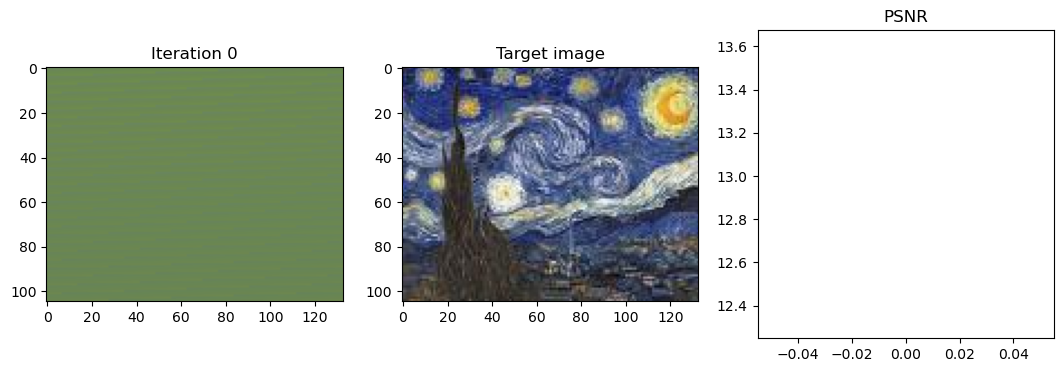

Iteration 2000  Loss: 0.0278  PSNR: 15.56 Time: 0.00 secs per iter 7.54 secs in total


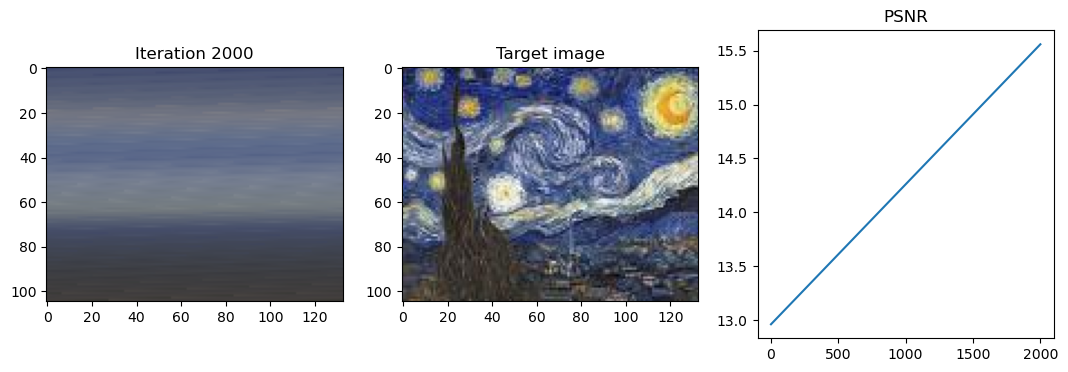

Iteration 4000  Loss: 0.0276  PSNR: 15.60 Time: 0.00 secs per iter 13.94 secs in total


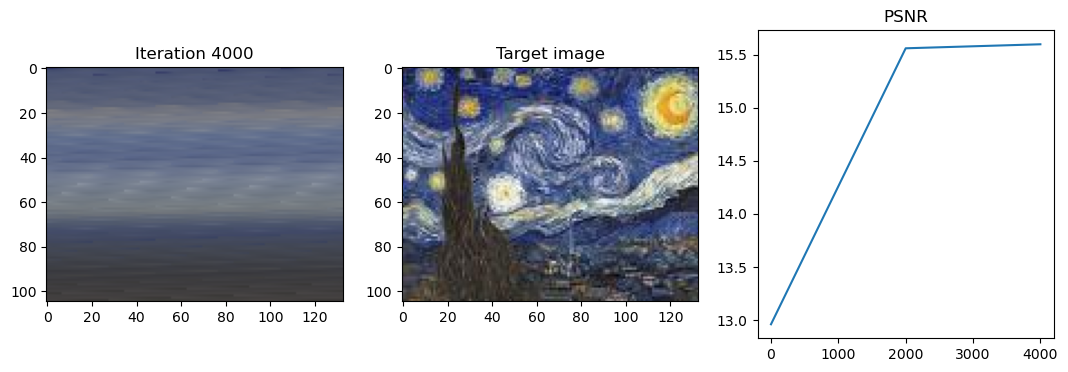

Iteration 6000  Loss: 0.0273  PSNR: 15.65 Time: 0.00 secs per iter 20.03 secs in total


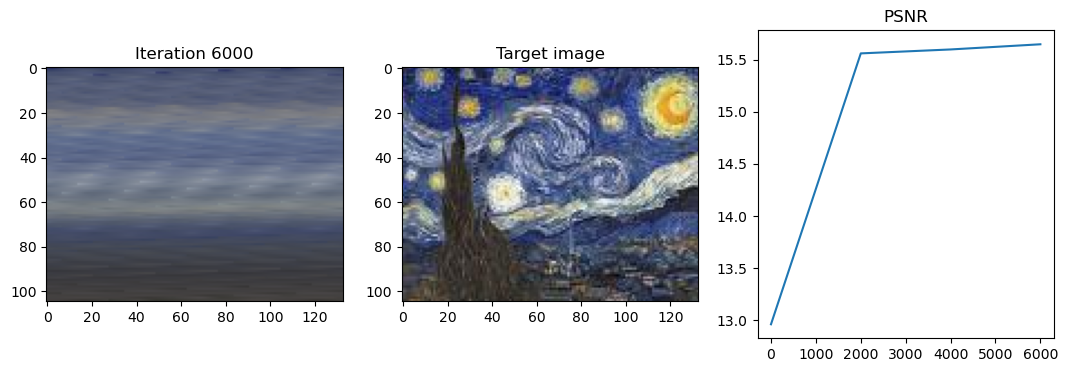

Iteration 8000  Loss: 0.0271  PSNR: 15.68 Time: 0.00 secs per iter 26.54 secs in total


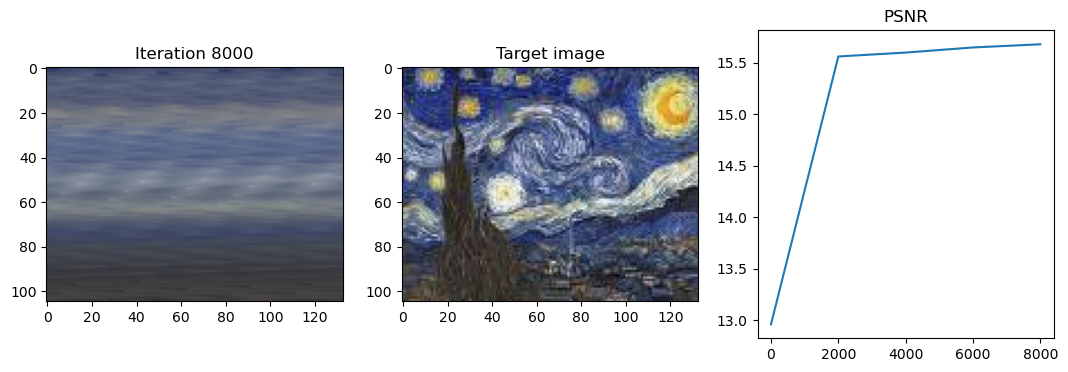

Iteration 10000  Loss: 0.0269  PSNR: 15.70 Time: 0.00 secs per iter 32.91 secs in total


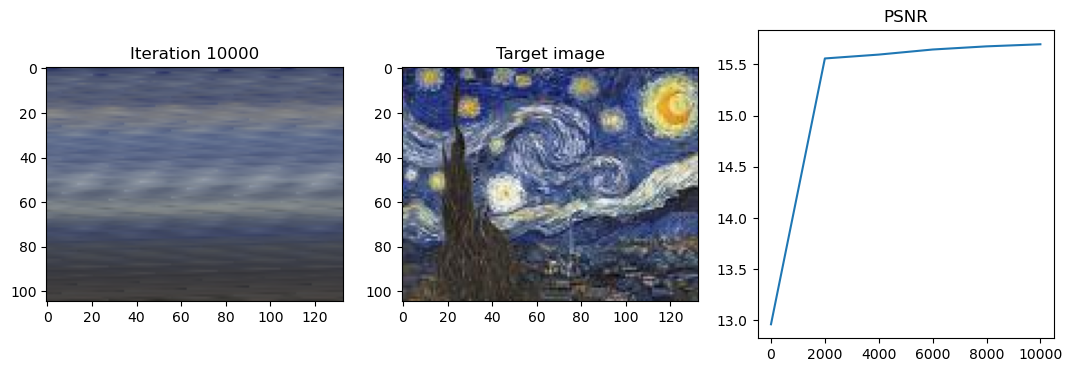

Done!
"Your PSNR 15.697054862976074 is smaller then 30!"


In [29]:
from src.vision.part1 import Model2d, train_2d_model

model = Model2d().to(device)
train_2d_model(model=model, height=height_painting, width=width_painting, testimg=painting)

## Part 1(a): Positional encoding
In class, we learned that standard coordinate-based MLPs cannot natively represent high-frequency functions on low-dimensional domains. 
To better preserve high frequency variation in the data, we can encode each of the scalar input coordinates with a sequence of sinusoids with exponentially increasing frequencies before passing them into the network.

Given a coordinate $𝐱$, we map each coordiante value $p$ in $𝐱$ with the encoding function $\gamma(⋅)$ as below:
$$γ(p)=(\text{sin}(2^0πp), \text{cos}(2^0πp), \text{sin}(2^1πp), \text{cos}(2^1πp), \cdots, \text{sin}(2^{L-2}πp), \text{cos}(2^{L-2}πp), \text{sin}(2^{L-1}πp), \text{cos}(2^{L-1}πp))$$
where the dimension of the output $γ(p)$ is $2L$.

If the input is a 2D coordinate $𝐱=(p_1,p_2)$, after positional encoding we will get a long vector with dimension $4L$:
$$(\text{sin}(2^0πp_1), \text{sin}(2^0πp_2), \text{cos}(2^0πp_1), \text{cos}(2^0πp_2), \text{sin}(2^1πp_1), \text{sin}(2^1πp_2), \text{cos}(2^1πp_1), \text{cos}(2^1πp_2), \cdots, \text{sin}(2^{L-2}πp_1), \text{sin}(2^{L-2}πp_2), \text{cos}(2^{L-2}πp_1), \text{cos}(2^{L-2}πp_2), \text{sin}(2^{L-1}πp_1), \text{sin}(2^{L-1}πp_2), \text{cos}(2^{L-1}πp_1), \text{cos}(2^{L-1}πp_2))$$

Similarly you can encode a 3D coordinate or an input signal of any dimension.
Complete the codes of `positional_encoding` in the file src/vision/part1.py

In [3]:
from tests.test_part1 import test_positional_encoding
from src.vision.utils import verify
print("Testing your positional_encoding:", verify(test_positional_encoding))

Testing your positional_encoding: "Correct"


You can now rerun the training to execute the training process. With positional encoding num_frequencies=6, you should get PSNR* $\sim$=27 after training for 10,000 iterations.

In [5]:
num_frequencies = 6
in_features = 2 * 2 * num_frequencies + 2
model = Model2d(in_features=in_features).to(device)
train_2d_model(model=model, num_frequencies=num_frequencies, height=height_painting, width=width_painting, testimg=painting)

NameError: name 'Model2d' is not defined

## Part 1(c) Improve the representation
Now, your task is to modify `Model2d`, such that **after training for 10,000 iterations with num_frequencies=6, PSNR is greater than or equal to 30**. Please do not change the model name, the name of the existing arguments, or the input/output dimensions. Hint: You can try different model structure (e.g. more/fewer layers, smaller/bigger hidden dimensions).


*[PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) is an image quality measurement. Higher PSNR generally indicates that the reconstruction is of higher quality.

Iteration 0  Loss: 0.0681  PSNR: 11.67 Time: 0.00 secs per iter 0.05 secs in total


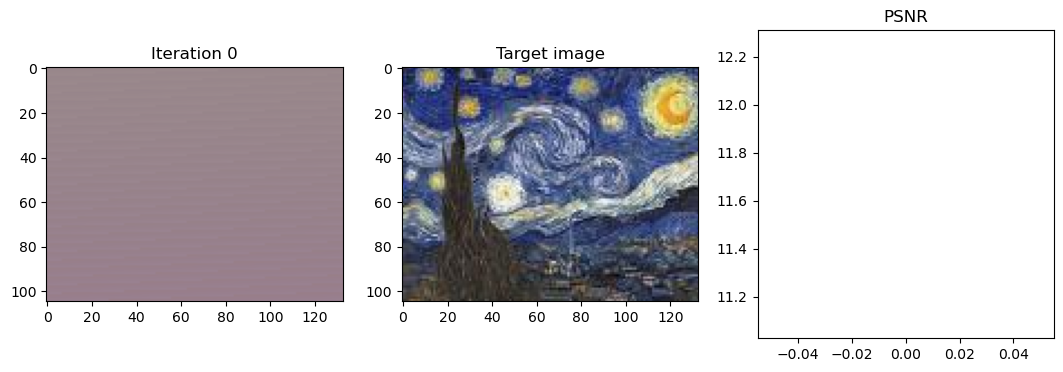

Iteration 2000  Loss: 0.0279  PSNR: 15.54 Time: 0.00 secs per iter 8.92 secs in total


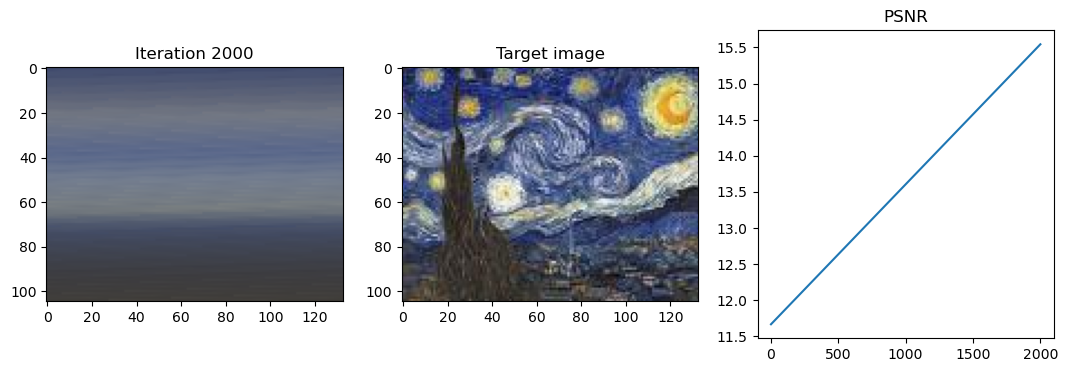

Iteration 4000  Loss: 0.0276  PSNR: 15.59 Time: 0.00 secs per iter 17.56 secs in total


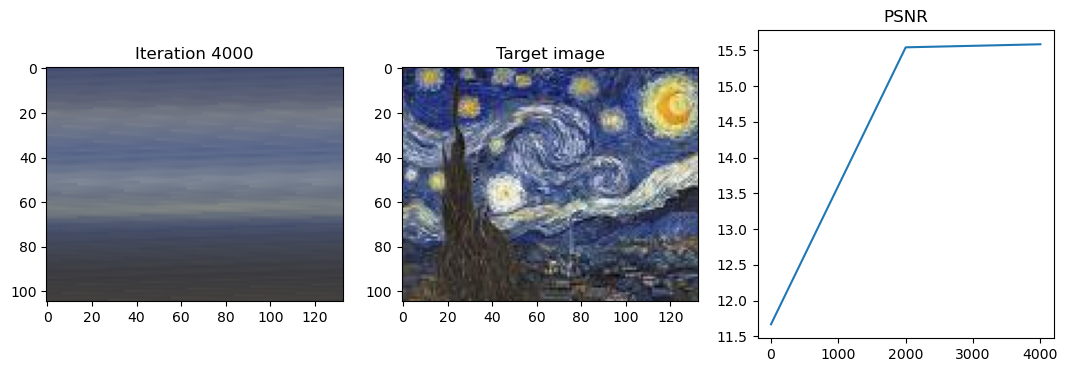

Iteration 6000  Loss: 0.0275  PSNR: 15.61 Time: 0.00 secs per iter 26.45 secs in total


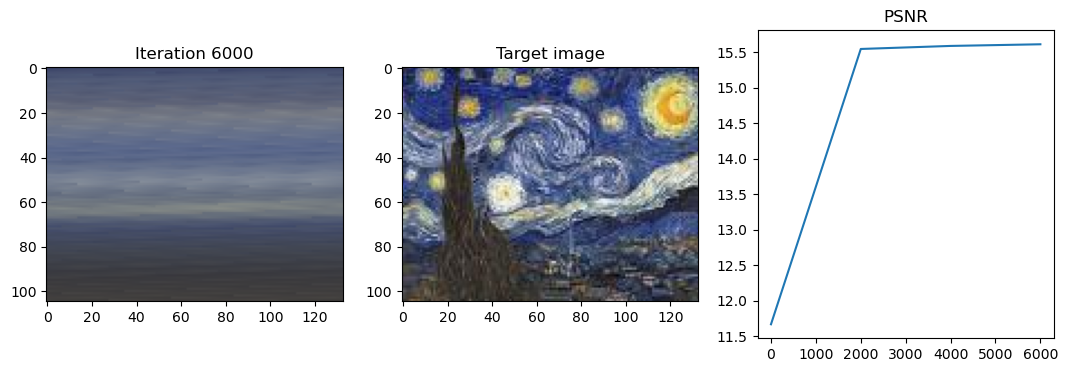

Iteration 8000  Loss: 0.0275  PSNR: 15.61 Time: 0.00 secs per iter 36.02 secs in total


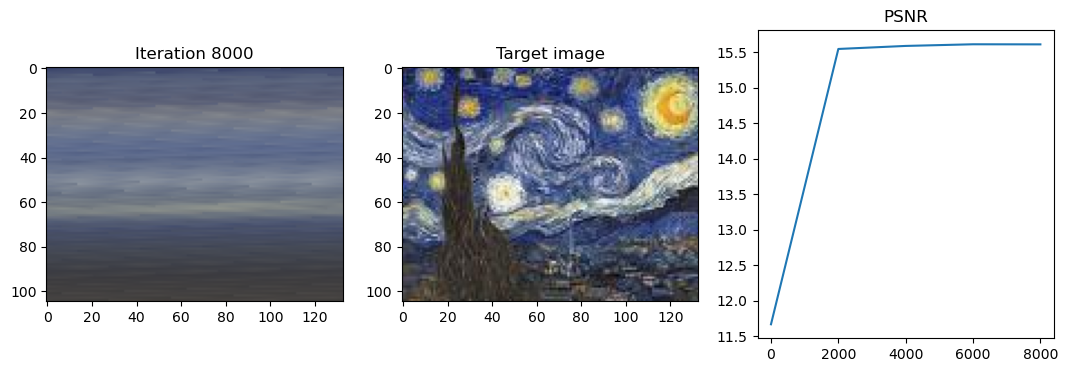

Iteration 10000  Loss: 0.0273  PSNR: 15.64 Time: 0.01 secs per iter 46.68 secs in total


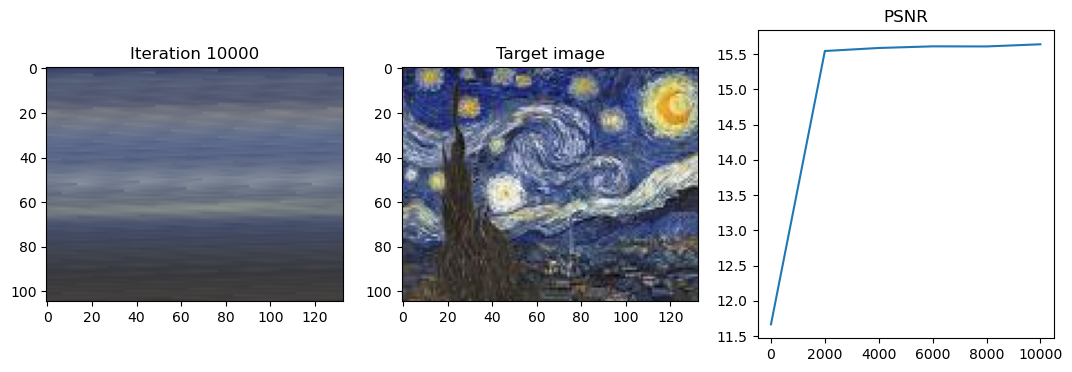

Done!
"Your PSNR 15.638519287109375 is smaller then 30!"


In [62]:
num_frequencies = 0
in_features = 2 * 2 * num_frequencies + 2
model = Model2d(hidden_features=512, in_features=in_features).to(device)
train_2d_model(model=model, num_frequencies=num_frequencies, height=height_painting, width=width_painting, testimg=painting)

# Part 2 Neural Radiance Field Scene Representation

A simplified version of NeRF represents a continous scene as a function using the following MLP network, whose input is a 3D location $\bf{x}=(x,y,z)$ and whose output is an RGB color $\bf{c}=(r,g,b)$ and volume density $\sigma$ at that 3D location.


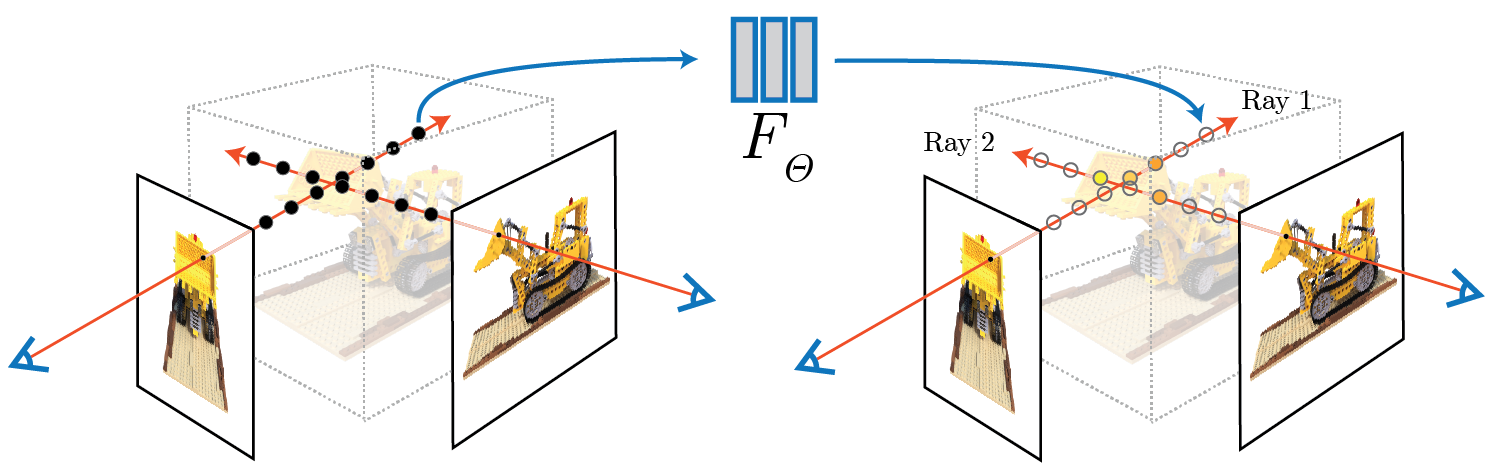

## Part 2(a)

You will implement the NeRF architecture in the `part2.py` file. Note: this isn't the exact architecture described in the original NeRF paper. It's been modified somewhat as we will not be using view-dependency in this project. Please refer to the docstrings in the source code for explanations on how to build the model.

## Part 2 (b), (c), (d), (e): Volume Rendering with Radiance Fields
A neural radiance field represents a scene as the volume density $\sigma$ and the RGB color $\bf c$ at any point in space. We can render an image from this neural radiance field by estimating the color at each pixel in the image by shooting a camera ray from that pixel through the scene, and accumulating color and density along the way. 

Rendering an image from neural radiance fields consists of four steps:
1. (b): given camera parameters, compute the origin and the direction of the camera ray through each pixel of the image in the world coordinate frame
2. (c): sample points along each camera ray and compute the sampled 3D points coordinates 
3. (d): generate the weights for the compositing based on density and transmittance 
4. (e): composite the colors and densities of the sampled points along a camera ray to get the final color of pixel

### Dataset
For the remainder of this project, you will be using the lego dataset. The lego dataset contains 100 training images and 1 test image, captured from viewpoints sampled on a upper hemisphere around the object looking towards a Lego bulldozer. The figure below shows some images from this dataset.

Run the script below to load in the lego dataset, load images and camera poses, and display the test image. 

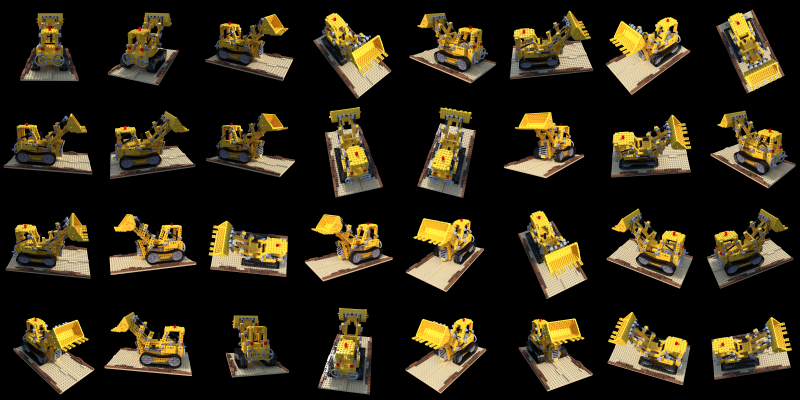

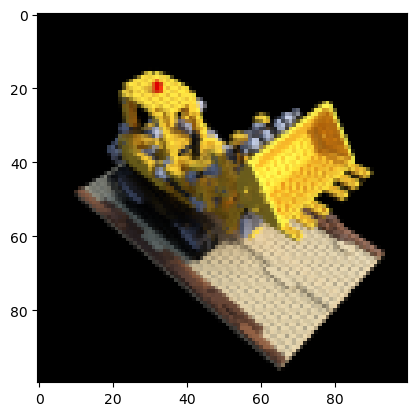

torch.Size([100, 100, 3])
tensor([[138.8889,   0.0000,  50.0000],
        [  0.0000, 138.8889,  50.0000],
        [  0.0000,   0.0000,   1.0000]], device='cuda:0')


In [10]:
# Load input images, poses, and intrinsics
data = np.load("lego_data_update.npz")

# Images
images = data["images"]

# Height and width of each image
height, width = images.shape[1:3]

# Camera extrinsics (poses)
tform_cam2world = data["poses"]
tform_cam2world = torch.from_numpy(tform_cam2world).to(device)

# Camera intrinsics
cam_intrinsics = data["intrinsics"]
cam_intrinsics = torch.from_numpy(cam_intrinsics).to(device)

# Near and far clipping thresholds for depth values.
near_thresh = 0.667
far_thresh = 2.

# Hold one image out (for test).
testimg, testpose = images[101], tform_cam2world[101]
testimg = torch.from_numpy(testimg).to(device)

# Rest images form test set
testset, testsetpose = images[101:], tform_cam2world[101:]
testset = torch.from_numpy(testset).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

plt.imshow(testimg.detach().cpu().numpy())
plt.show()

print(testimg.shape)
# print(tform_cam2world.shape)
# print(tform_cam2world[0])
print(cam_intrinsics)

### Part 2(b): Compute the origin and direction of rays through all pixels of an image.

The goal of this TODO is to compute the origin and the direction of camera ray through each pixel of the image in the world coordinate space. This part is related to the concepts you learned in [Lecture 2: Camera Projection and Image Filtering](https://faculty.cc.gatech.edu/~hays/compvision/lectures/02.pdf) and [Lecture 10: Camera Calibration, Stereo intro](https://faculty.cc.gatech.edu/~hays/compvision/lectures/10.pdf).

1. Get the all pixel coordinates in the image space (shape: `[height, width, 2])`. Each 2D coordinate is (x, y), where x is the index along the horizontal axis, and y is the index along the vertical axis.
2. Transform image coordinates into camera coordinates using the camera intrinsics $𝐊$. You should first turn each pixel coordinate (x, y) into homogeneous coordinates (x, y, 1) and then apply $𝐊$ in some way. Remember that $𝐊$ transforms camera coordinates into image coordinates, while here you are supposed to do the opposite.
3. In fact, the coordinates you computed in step 2 are exactly the directions of each ray in the camera coordinate space, because they can be viewed as a vector starting from the camera origin (0, 0, 0). Your task is to convert both the camera origin, and the direction of each ray to the world coordinate frame. You should use our provided camera to world transformation matrix `tform_cam2world`.


***Note: in the function `get_rays()`, you are not allowed to use for loops. Instead, you should use pytorch vectorized functions (such as torch.meshgrid, torch.matmul, torch.stack) to ensure efficient code.***



#### Test case for Part 2(b)
test function `get_rays()`

In [62]:
from tests.test_part2 import test_get_rays

print("Test test_get_rays:", verify(test_get_rays))

Test test_get_rays: "Correct"


### Part 2(c): Sample the 3D points on the camera rays.

Given the origin $𝐨$ and the direction $𝐝$ of a ray, we want to sample 3D points $𝐱$ on this ray. The sampling range is bounded by the near and far threshold, denoted as $t_n, t_f$. In order to ensure the ray to is thoroughly sampled during training, we evenly partition the ray into $N$ bins and uniformly sample one point in each bin.

$$𝐱_i=𝐨 + t_i𝐝$$
$$t_i ∼ 𝑼[t_n+\frac{i-1}{N}(t_f-t_n), t_n+\frac{i}{N}(t_f-t_n)]$$

where $t_i, i=\{1,\cdots,N\}$ is the sampled depth value.

In the function of `sample_points_from_rays`, there is an argument called `randomize`. When `randomize` is `True`, you should sample one point uniformly at random from each bin.
When `randomize` is `False`, you should instead sample the lower bound of each bin, i.e., 
$$t_i = t_n+\frac{i-1}{N}(t_f-t_n)$$

#### Test case for Part 2(c)

test function `sample_points_from_rays()`

In [63]:
from tests.test_part2 import test_sample_points
print("Test sample_points_from_rays:", verify(test_sample_points))

error_points:  0.0
errordepth:  0.0
Test sample_points_from_rays: "Correct"


### Part 2(d): Compute compositing weight of samples on camera ray (pre-step of volume rendering)

The expected color $C(𝐫)$ of camera ray 𝐫 in the continuous space can be computed with the formula:
$$C(𝐫)=\int_{t_n}^{t_f}T(t)\sigma(𝐫(t))𝐜(𝐫(t),𝐝)dt$$
where $T(t)=\text{exp}(-\int_{t_n}^{t}\sigma(𝐫(s))ds)$ denotes the accumulated transmittance along the ray from $t_n$ to $t$, i.e., the probability that the ray doesn't hit any other particle from $t_n$ to $t$.

To numerically and differentiably estimate this continous integral, we use a discrete set of samples with the quadrature rule as follows:
$$\hat{C}(𝐫)=\sum_{i=1}^{N}T_i(1-\text{exp}(-\sigma_iδ_i))𝐜_i$$
where N is the number of samples, $T_i=\text{exp}(-\sum_{j=1}^{i-1}\sigma_iδ_i)$, and $δ_i=t_{i+1}-t_i$ is the distance between adjacent samples. From sampled depth values $t_i, i=1,\cdots,N$, you can get distances $δ_i, i=1,\cdots,N-1$, and you should append a huge number $1e9$ as the last distance $δ_N$. 

In the function `compute_compositing_weights`, your task is to compute the weight $w_i =  T_i(1-\text{exp}(-\sigma_iδ_i))$ for each query point. In the next TODO (Part 2(e)), you will be using the computed weights $w_i$ to composite $𝐜_i$ into a pixel color ($\hat{C}(𝐫)=\sum_{i=1}^{N}w_i𝐜_i$).

#### Test case for Part 2(d)
test function `compute_compositing_weights()`

In [64]:
from tests.test_part2 import test_compute_compositing_weights
print("Test test_compute_compositing_weights:", verify(test_compute_compositing_weights))

Test test_compute_compositing_weights: "Correct"


### Part 2(e): render one image with NeRF
To render an image with NeRF, we will combine the previous TODO implemenations in the following steps:
1. compute the camera rays (2(b))
2. sample 3D points on rays (2(c))
3. positionally encode the sampled points (TODO 1(a))
4. feed the encoded points into the network (`model`) to compute the color and volume density $\sigma$ for each point
5. use volume density $\sigma$ to compute the compositing weights of samples on a ray (2(d))
6. compute the pixel color by integrating colors of all samples along a ray, i.e. weighted sum of the color value according to the compositing weight as below
$$\hat{C}(𝐫)=\sum_{i=1}^{N}w_i𝐜_i$$
This will allow us to render a final RGB image. To render a depth map instead, simply replace colors to sampled depth values, i.e., $\hat{D}(𝐫)=\sum_{i=1}^{N}w_it_i$.

#### Test case for Part 2(e)

predicted:  tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0') 
groundTruth:  tensor([[[0., 0., 

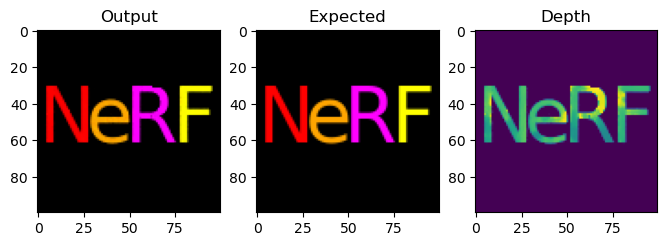

Test render_image_test: "Correct"


In [65]:
from tests.test_part2 import render_image_test

print("Test render_image_test:", verify(render_image_test, device=device))

# Part3 Train NeRF on 360 scene
Your next task is to complete `train_nerf()` in part3.py. Once you've completed the code to properly train the NeRF model, proceed with training it with the code block below!

After training for 1,000 iterations with `num_encoding_functions=6`, you should expect to achieve a PSNR greater than or equal to 20.

Note: The training can get stuck at local optimum with certain initialization, in which can the PSNR will not improve with more training. You can rerun the code to restart training.

**NOTE:** If you are using apple silicon or nvidia gpus, you can keep running following training cells on your computer. If you prefer using Google Colab for training, please refer to the instruciton in Section 3.1 of project handout.

In [11]:
from src.vision.part3 import train_nerf

num_iters = 1000
depth_samples_per_ray = 64

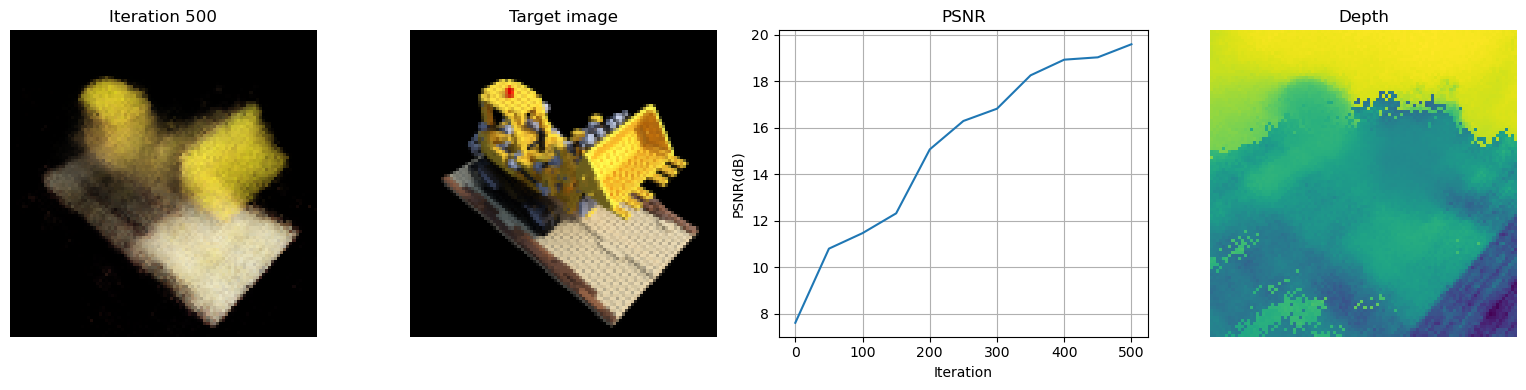

training NeRF:  50%|████████████████████████████████▏                               | 503/1001 [10:47<10:41,  1.29s/it]


KeyboardInterrupt: 

In [12]:
"""
Training NeRF
"""


 

model, encode_pts, encode_view, training_snaps_rgb, training_snaps_depth = train_nerf(
    images, tform_cam2world, cam_intrinsics, testpose, testimg, height, width,
    near_thresh, far_thresh, device=device, num_frequencies=(8,4),
    depth_samples_per_ray=depth_samples_per_ray, lr=5e-4, num_iters=num_iters, display_every=50
)

## Interactive visualization
Training finished!

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive, widgets
from IPython.display import display

# --- 1. Prepare Dummy Data (Replace this with your actual data) ---
# Assuming rgb_predicted is a list/tensor of images.
# Let's create a dummy list of 10 random 64x64 RGB images for demonstration.
# Your actual data (rgb_predicted) seems to be PyTorch tensors,
# which you are already correctly converting using .detach().cpu().numpy().

# The list has 10 images, so i will range from 0 to 9.
num_snapshots = training_snaps_depth.shape[0]
print(training_snaps_depth.shape)
# --- 2. Define the Plotting Function ---
def view_image(i):
    """
    Plots the i-th image from the rgb_predicted list.
    This function will be controlled by the interactive widget.
    """
    # Clear the previous figure to avoid overlap in some environments
    plt.close('all')

    # Create a new figure and axis for the current plot
    fig, axes = plt.subplots(1, 3, figsize=(16,3))

    # Get the image data, ensuring it is a NumPy array
    rgb_data = training_snaps_rgb[i]
    depth_data = training_snaps_depth[i]

    axes[0].imshow(testimg.cpu().numpy())
    axes[0].set_title("Target image")
    axes[0].axis('off')
    
    
    # Plot the image
    axes[1].imshow(rgb_data)
    axes[1].set_title(f'Image Index: {i}')
    axes[1].axis('off')
    

    axes[2].imshow(depth_data)
    axes[2].set_title("Depth")
    axes[2].axis('off')

    # Display the plot
    plt.show()

# --- 3. Create the Slider Widget and Connect it to the Function ---

# Define the slider widget. We want an integer slider.
# widgets.IntSlider(min, max, step, description)
image_index_slider = widgets.IntSlider(
    min=0,
    max=num_snapshots - 1, # Max index is length - 1
    step=1,
    description='Image Index:',
    value=0, # Start at the first image
    style={'description_width': 'initial'}
)

# Use the interactive function to link the widget to the plot function.
# The keyword argument 'i' must match the function argument name in view_image.
interactive_plot = interactive(view_image, i=image_index_slider)

# --- 4. Display the Interactive Plot ---
display(interactive_plot)

NameError: name 'training_snaps_depth' is not defined

In [24]:
from src.vision.part2_view_dep import render_image_nerf

trans_t = lambda t : np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=np.float32)

rot_phi = lambda phi : np.array([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=np.float32)

rot_theta = lambda th : np.array([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=np.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    c2w = c2w @ np.array([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
    c2w = np.array(c2w, dtype=np.float32)
    return c2w

%matplotlib inline
from ipywidgets import interactive, widgets
def f(**kwargs):
    render_poses = torch.from_numpy(pose_spherical(**kwargs)).to(device)
    rgb_predicted, _ = render_image_nerf(height, width, cam_intrinsics,
                                              render_poses[:3,:4], near_thresh,
                                              far_thresh, depth_samples_per_ray,
                                              encode_pts, encode_view, model)
    img = np.clip(rgb_predicted.detach().cpu().numpy(),0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [1.5, 1., 2.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

## Qualitative evaluation
Create a 360 video with the trained NeRF by rendering a set of images around the object. Evaluate the novel view synthesis results qualitatively.

In [19]:
import imageio
# 360 video
import tqdm

with torch.no_grad():
  rgbs = []
  for th in tqdm.tqdm(np.linspace(0., 360., 120, endpoint=False)):
      render_poses = torch.from_numpy(pose_spherical(th, -30., 1.4)).to(device)
      rgb_predicted, _ = render_image_nerf(height, width, cam_intrinsics,
                                              render_poses[:3,:4], near_thresh,
                                              far_thresh, depth_samples_per_ray,
                                              encode, model)
      rgbs.append(rgb_predicted.detach().cpu().numpy())
rgbs = np.array(rgbs)
print('Done, saving', rgbs.shape)
moviebase = os.path.join('{}_spiral_{:06d}_'.format("lego", num_iters))
to8b = lambda x : (255*np.clip(x,0,1)).astype(np.uint8)
imageio.mimwrite(moviebase + 'rgb.mp4', to8b(rgbs), fps=30, quality=8)

from IPython.display import HTML
from base64 import b64encode
mp4 = open(moviebase + 'rgb.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

  0%|                                                                                          | 0/120 [00:00<?, ?it/s]


NameError: name 'encode' is not defined

## Quantitive results
Evaluate the novel view synthesis results quantitatively on the test set with PSNR metric. Expect to reach PSNR greater than or equal to 20.

In [153]:
psnrs = []
for i in range(testset.shape[0]):
  with torch.no_grad():
    rgb_predicted, depth_predicted = render_image_nerf(height, width, cam_intrinsics,
                                            testsetpose[i], near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, model)
  loss = F.mse_loss(rgb_predicted, testset[i])
  psnr = -10. * torch.log10(loss)
  psnrs.append(psnr.item())
print("PSNR on test set: %.2f" % np.mean(np.array(psnrs)))

PSNR on test set: 23.66


# higher quality

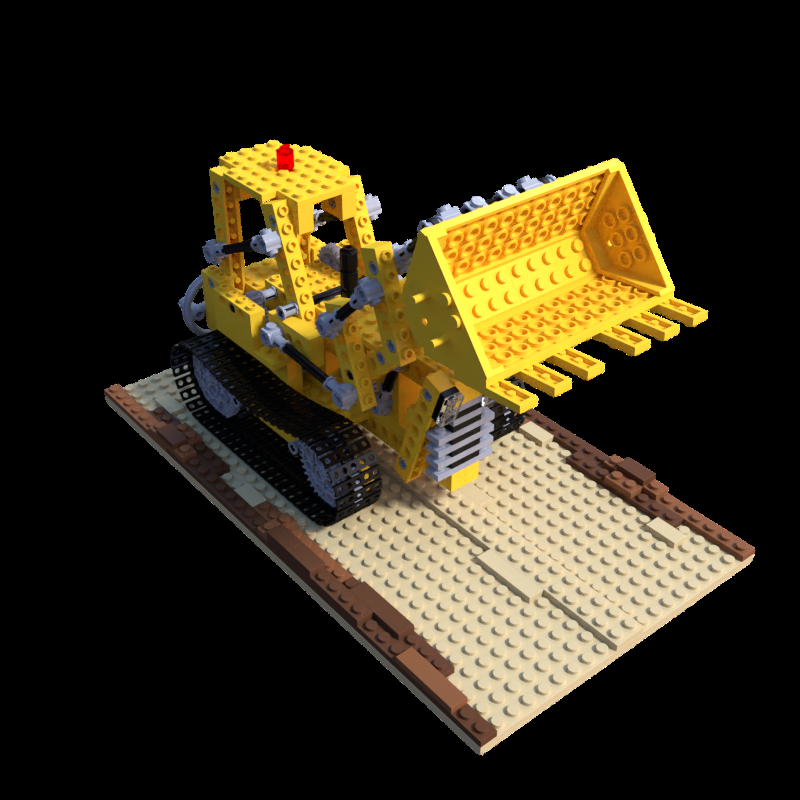

Image shape (H, W, C): (800, 800, 3)


In [13]:
from PIL import Image
root_dir = "./nerf_synthetic/lego/"
path = os.path.expanduser(root_dir)
hard_code_path = "./nerf_synthetic/lego/train/r_24.png"


img = Image.open(hard_code_path).convert('RGB')
display(img)
img_array = np.array(img)
print(f"Image shape (H, W, C): {img_array.shape}")

## Running the Trainingloop with dataset and data loader

In [14]:
import torch
import matplotlib.pyplot as plt
from src.vision.nerf_trainer import Trainer
from src.vision.part2_view_dep import NerfModel
from tqdm.notebook import tqdm
import time

torch.cuda.empty_cache()
# Hyperparameters & Paths
data_dir = "./nerf_synthetic/lego/"
model_dir = "./checkpoints/"
# near_t, far_t = 2.0, 6.0
near_t, far_t = 0.667, 2.0
num_frequencies=(6,4) # works for (6,4) but fails for (4,4)??????

# Initialize Model & Optimizer
# Note: encode_channels should match your positional encoding frequencies
encode_channels = (num_frequencies[0] * 2 * 3) + 3 # (num_freqs * 2 * dimensions) + input
model = NerfModel(encode_channels,filter_size=256, freq=num_frequencies).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

test_image_path = "C:/Users/The_M/Documents/GeorgiaTech/cs6476/project-6-student/nerf_synthetic/lego/train/r_24.png"
testimg = Image.open(test_image_path).convert('RGB')
new_size = (100, 100)
testimg = testimg.resize(new_size, Image.Resampling.LANCZOS)
testimg_tensor = torchvision.transforms.ToTensor()(testimg).permute(1,2,0)
print(testimg_tensor.shape)
testpose = torch.tensor([
                [
                    0.30901747941970825,
                    0.6045553088188171,
                    -0.7341805100440979,
                    -2.959576368331909
                ],
                [
                    -0.9510563015937805,
                    0.19643229246139526,
                    -0.23855014145374298,
                    -0.9616263508796692
                ],
                [
                    0.0,
                    0.7719632387161255,
                    0.6356672048568726,
                    2.5624563694000244
                ],
                [
                    0.0,
                    0.0,
                    0.0,
                    1.0
                ]
            ])

testpose *= (100/800)
testpose[-1, -1] = 1

torch.Size([100, 100, 3])


In [15]:
def test_memory_usage(model, intrinsics, tform_cam2world, encoding_fn_pts, encoding_fn_view,
                      test_sizes=[(200, 200), (400, 400), (800, 800)]):
    """Test memory usage at different resolutions."""
    
    # near_thresh, far_thresh = 2.0, 6.0
    near_thresh = 0.667
    far_thresh = 2.
    depth_samples = 64
    
    for height, width in test_sizes:
        print(f"\nTesting {height}x{width}...")
        
        # Clear cache
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        
        try:
            # Render image
            with torch.no_grad():
                rgb, depth = render_image_nerf(
                    height, width, intrinsics, tform_cam2world,
                    near_thresh, far_thresh, depth_samples,
                    encoding_fn_pts, encoding_fn_view, model
                )
            
            # Report memory
            max_memory = torch.cuda.max_memory_allocated() / 1024**3  # GB
            print(f"✓ Success! Peak memory: {max_memory:.2f} GB")
            print(f"  Output shape: RGB {rgb.shape}, Depth {depth.shape}")
            
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"✗ OOM Error at {height}x{width}")
                print(f"  Try reducing rays_per_batch or depth_samples_per_ray")
            else:
                raise e

In [16]:
trainer = Trainer(
    data_dir = data_dir,
    model_dir=model_dir,
    model=model,
    optimizer=optimizer,
    device=device_type,
    near_thresh = near_t,
    far_thresh = far_t,
    testpose=testpose,
    testimg=testimg_tensor,
    batch_size = 1,
    load_from_disk = False,
    cuda = True,
    num_frequencies=num_frequencies,
)

nerf_synthetic\lego\train\r_0.png
nerf_synthetic\lego\test\r_0.png


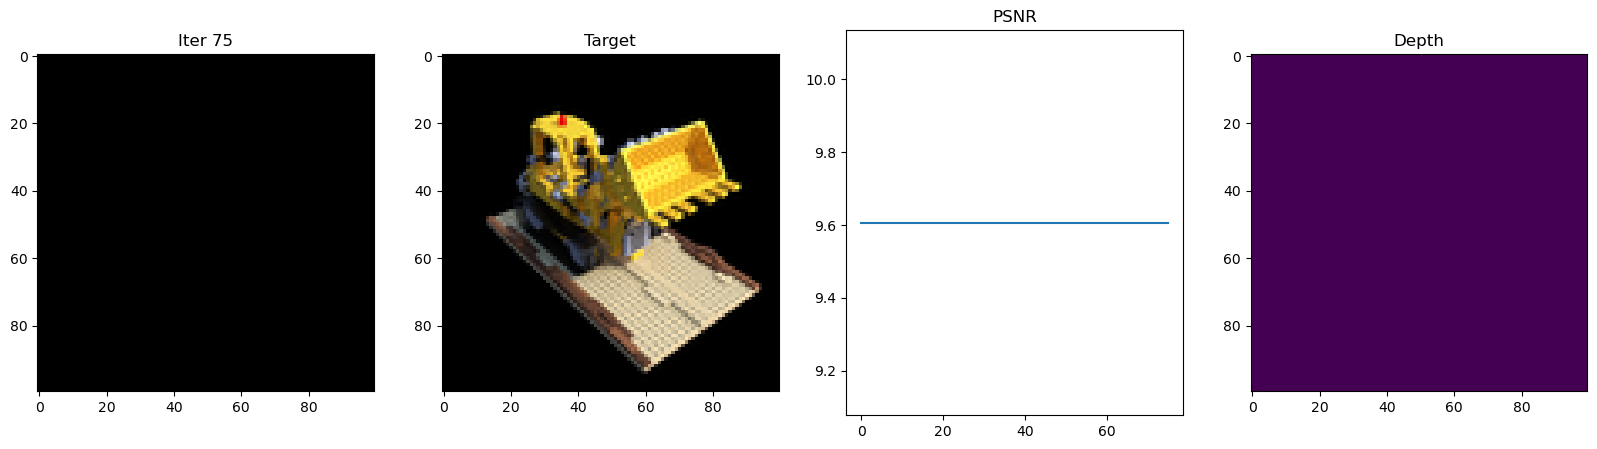

In [ ]:
# Create a figure for real-time updates (matches part3.py style)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
## create a method in the class where it runs this and returns the lsit of all rendered iamges
# Run training
num_epochs = 1
for epoch in tqdm(range(num_epochs)):
    tqdm.write(f"Starting Epoch {epoch}")
    trainer.train_epoch(fig, axes, epoch, 25)
    time.sleep(0.01)

In [19]:
trainer_loop = Trainer(
    data_dir = data_dir,
    model_dir=model_dir,
    model=model,
    optimizer=optimizer,
    device=device_type,
    near_thresh = near_t,
    far_thresh = far_t,
    testpose=testpose,
    testimg=testimg_tensor,
    batch_size = 1,
    load_from_disk = False,
    cuda = True,
    num_frequencies=num_frequencies,
)

model_dl, encode_pts_dl, encode_view_dl, training_snaps_rgb_dl, training_snaps_depth_dl = trainer_loop.run_training_loop(10, 25)

Training completed!
(40, 100, 100, 3) (40, 100, 100)


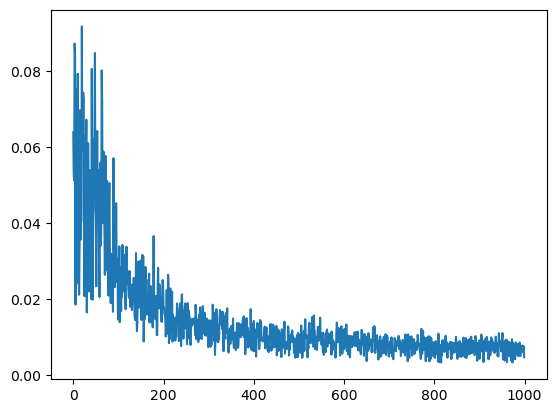

In [26]:
# Convert each tensor in the list to CPU and then to a numpy array (or float)
clean_losses = [loss.cpu().detach().numpy() for loss in trainer_loop.train_loss_history]

plt.plot(clean_losses)
plt.show()

In [33]:
torch.save(model_dl.state_dict(), os.path.join('output', 'nerf_model_data_loader_renders_img.pth'))

AcceleratorError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [31]:
model_dl, encode_pts_dl, encode_view_dl, training_snaps_rgb_dl, training_snaps_depth_dl = trainer_loop.run_training_loop(1, 100)

  0%|          | 0/1 [00:00<?, ?it/s]

Starting Epoch 0


Processing Batches:   0%|          | 0/100 [00:00<?, ?it/s]

AcceleratorError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
testimg_tensor_noperm = torchvision.transforms.ToTensor()(testimg)
model_noperm = NerfModel(encode_channels,filter_size=256, freq=num_frequencies).to(device)
optimizer_noperm = torch.optim.Adam(model.parameters(), lr=5e-4)
trainer_loop_noperm = Trainer(
    data_dir = data_dir,
    model_dir=model_dir,
    model=model_noperm,
    optimizer=optimizer_noperm,
    device=device_type,
    near_thresh = near_t,
    far_thresh = far_t,
    testpose=testpose,
    testimg=testimg_tensor_noperm,
    batch_size = 1,
    load_from_disk = False,
    cuda = True,
    num_frequencies=num_frequencies,
)

model_noperm, encode_pts_noperm, encode_view_noperm, training_snaps_rgb_noperm, training_snaps_depth_noperm = trainer_loop_noperm.run_training_loop(10, 25)

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive, widgets
from IPython.display import display

# --- 1. Prepare Dummy Data (Replace this with your actual data) ---
# Assuming rgb_predicted is a list/tensor of images.
# Let's create a dummy list of 10 random 64x64 RGB images for demonstration.
# Your actual data (rgb_predicted) seems to be PyTorch tensors,
# which you are already correctly converting using .detach().cpu().numpy().

# The list has 10 images, so i will range from 0 to 9.
num_snapshots = training_snaps_depth.shape[0]
print(training_snaps_depth.shape)
# --- 2. Define the Plotting Function ---
def view_image(i, rgb_list, depth_list):
    """
    Plots the i-th image from the rgb_predicted list.
    This function will be controlled by the interactive widget.
    """
    # Clear the previous figure to avoid overlap in some environments
    plt.close('all')

    # Create a new figure and axis for the current plot
    fig, axes = plt.subplots(1, 3, figsize=(16,3))

    # Get the image data, ensuring it is a NumPy array
    rgb_data = rgb_list[i]
    depth_data = depth_list[i]

    axes[0].imshow(testimg.cpu().numpy())
    axes[0].set_title("Target image")
    axes[0].axis('off')
    
    
    # Plot the image
    axes[1].imshow(rgb_data)
    axes[1].set_title(f'Image Index: {i}')
    axes[1].axis('off')
    

    axes[2].imshow(depth_data)
    axes[2].set_title("Depth")
    axes[2].axis('off')

    # Display the plot
    plt.show()

# --- 3. Create the Slider Widget and Connect it to the Function ---

# Define the slider widget. We want an integer slider.
# widgets.IntSlider(min, max, step, description)
image_index_slider = widgets.IntSlider(
    min=0,
    max=num_snapshots - 1, # Max index is length - 1
    step=1,
    description='Image Index:',
    value=0, # Start at the first image
    style={'description_width': 'initial'}
)

# Use the interactive function to link the widget to the plot function.
# The keyword argument 'i' must match the function argument name in view_image.
interactive_plot = interactive(view_image, i=image_index_slider, rgb_list=training_snaps_rgb_dl, depth_list=training_snaps_depth_dl)

# --- 4. Display the Interactive Plot ---
display(interactive_plot)

NameError: name 'training_snaps_depth' is not defined

In [20]:
from src.vision.part2_view_dep import render_image_nerf
import src.vision.nerf_dataloader as nerf_dataloader

trans_t = lambda t : np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=np.float32)

rot_phi = lambda phi : np.array([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=np.float32)

rot_theta = lambda th : np.array([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=np.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    c2w = c2w @ np.array([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
    c2w = np.array(c2w, dtype=np.float32)
    return c2w
    
dataset = nerf_dataloader.SpatialImg(
    root_dir="./nerf_synthetic/lego/",
    split="train",
    scaled_size=(100, 100)
)

%matplotlib inline
from ipywidgets import interactive, widgets
def f(**kwargs):
    render_poses = torch.from_numpy(pose_spherical(**kwargs)).to(device)
    rgb_predicted, _ = render_image_nerf(100, 100, dataset.cam_intrinsics.to(device),
                                              render_poses[:3,:4], near_t,
                                              far_t, 64,
                                              encode_pts_dl, encode_view_dl, model_dl)
    img = np.clip(rgb_predicted.detach().cpu().numpy(),0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [1.5, 1., 2.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot

nerf_synthetic\lego\train\r_0.png


interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Comparining npz with dataloader after change:

In [ ]:
import src.vision.nerf_dataloader as nerf_dataloader
from PIL import Image

def compare_datasets(index, dataset, npz_images, npz_poses, npz_intrinsics, output: bool = True):
    # Compare first image
    img0_dataloader, pose0_dataloader = dataset[index]
    img0_dataloader = img0_dataloader.to(device)
    img0_dataloader.detach().cpu()
    
    img0_npz = npz_images[index]
    img0_npz = torch.from_numpy(img0_npz).to(device)
    img0_npz.detach().cpu()

    img_diff = torch.abs(img0_dataloader - img0_npz).mean()
    pose_diff = np.abs(pose0_dataloader.numpy() - npz_poses[index]).mean()
    intrin_diff = np.abs(dataset.cam_intrinsics.numpy() - npz_intrinsics).mean()
    
    
   


    
    if output:

         # img = Image.open(hard_code_path).convert('RGB')
        # display(img0_dataloader)
        # import matplotlib.pyplot as plt
        
        # If your tensor is [H, W, 3]
        plt.imshow(img0_dataloader.detach().cpu().numpy())
        plt.show()
        # img_array = np.array(img)
        
        
        plt.imshow(img0_npz.detach().cpu().numpy())
        plt.show()
        
        print("="*60)
        print("IMAGE COMPARISON")
        print(f"Dataloader image shape: {img0_dataloader.shape}")
        print(f"NPZ image shape: {img0_npz.shape}")
        print(f"Dataloader image range: [{img0_dataloader.min():.4f}, {img0_dataloader.max():.4f}]")
        print(f"NPZ image range: [{img0_npz.min():.4f}, {img0_npz.max():.4f}]")
        
        print(f"Mean absolute difference: {torch.abs(img0_dataloader - img0_npz).mean():.6f}")
        print()
        
        print("POSE COMPARISON")
        print(f"Dataloader pose shape: {pose0_dataloader.shape}")
        print(f"NPZ pose shape: {npz_poses[index].shape}")
        print("Dataloader pose:\n", pose0_dataloader)
        print("NPZ pose:\n", npz_poses[index])
        
        print(f"Mean absolute difference: {np.abs(pose0_dataloader.numpy() - npz_poses[index]).mean():.6f}")
        print()
        
        print("INTRINSICS COMPARISON")
        print(f"Dataloader intrinsics:\n{dataset.cam_intrinsics}")
        print(f"NPZ intrinsics:\n{npz_intrinsics}")
        
        print(f"Mean absolute difference: {np.abs(dataset.cam_intrinsics.numpy() - npz_intrinsics).mean():.6f}")
        print("="*60)

    return img_diff, pose_diff, intrin_diff

In [ ]:
# In your notebook:
# Load NPZ data
data = np.load("lego_data_update.npz")
npz_images = data["images"]
npz_poses = data["poses"]
npz_intrinsics = data["intrinsics"]

# Load from dataloader
dataset = nerf_dataloader.SpatialImg(
    root_dir="./nerf_synthetic/lego/",
    split="train",
    scaled_size=(100, 100)
)

big_diff_list = []

for i in range(20):
    diff, p_diff, t_diff = compare_datasets(i, dataset, npz_images, npz_poses, npz_intrinsics, output=False)
    if diff > 0.01 or p_diff > 0.0001 or t_diff > 0.001:
        big_diff_list.append((i, diff, p_diff, t_diff))

print(len(big_diff_list))
print(big_diff_list)



# comparing before change:

In [ ]:
from src.vision.part2_view_dep import render_image_nerf

trans_t = lambda t : np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=np.float32)

rot_phi = lambda phi : np.array([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=np.float32)

rot_theta = lambda th : np.array([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=np.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    c2w = c2w @ np.array([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
    c2w = np.array(c2w, dtype=np.float32)
    return c2w

%matplotlib inline
from ipywidgets import interactive, widgets
def f(**kwargs):
    render_poses = torch.from_numpy(pose_spherical(**kwargs)).to(device)
    rgb_predicted, _ = render_image_nerf(height, width, cam_intrinsics,
                                              render_poses[:3,:4], near_thresh,
                                              far_thresh, depth_samples_per_ray,
                                              encode_pts, encode_view, model)
    img = np.clip(rgb_predicted.detach().cpu().numpy(),0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [1.5, 1., 2.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot

In [ ]:
import src.vision.nerf_dataloader as nerf_dataloader
from PIL import Image
# In your notebook:
# Load NPZ data
data = np.load("lego_data_update.npz")
npz_images = data["images"]
npz_poses = data["poses"]
npz_intrinsics = data["intrinsics"]

# Load from dataloader
dataset = nerf_dataloader.SpatialImg(
    root_dir="./nerf_synthetic/lego/",
    split="train",
    scaled_size=(100, 100)
)

# Compare first image
img0_dataloader, pose0_dataloader = dataset[0]
img0_dataloader = img0_dataloader.to(device)
img0_npz = npz_images[0]


# img = Image.open(hard_code_path).convert('RGB')
# display(img0_dataloader)
# import matplotlib.pyplot as plt

# If your tensor is [H, W, 3]
plt.imshow(img0_dataloader.detach().cpu().numpy())
plt.show()
# img_array = np.array(img)

img0_npz = torch.from_numpy(img0_npz).to(device)
plt.imshow(img0_npz.detach().cpu().numpy())
plt.show()

print("="*60)
print("IMAGE COMPARISON")
print(f"Dataloader image shape: {img0_dataloader.shape}")
print(f"NPZ image shape: {img0_npz.shape}")
print(f"Dataloader image range: [{img0_dataloader.min():.4f}, {img0_dataloader.max():.4f}]")
print(f"NPZ image range: [{img0_npz.min():.4f}, {img0_npz.max():.4f}]")
print(f"Mean absolute difference: {torch.abs(img0_dataloader - img0_npz).mean():.6f}")
print()

print("POSE COMPARISON")
print(f"Dataloader pose shape: {pose0_dataloader.shape}")
print(f"NPZ pose shape: {npz_poses[0].shape}")
print("Dataloader pose:\n", pose0_dataloader)
print("NPZ pose:\n", npz_poses[0])
print(f"Mean absolute difference: {np.abs(pose0_dataloader.numpy() - npz_poses[0]).mean():.6f}")
print()

print("INTRINSICS COMPARISON")
print(f"Dataloader intrinsics:\n{dataset.cam_intrinsics}")
print(f"NPZ intrinsics:\n{npz_intrinsics}")
print(f"Mean absolute difference: {np.abs(dataset.cam_intrinsics.numpy() - npz_intrinsics).mean():.6f}")
print("="*60)